# <center>Проект 6. Сегментация клиентов онлайн-магазина</center>

## 1. Постановка задачи


В данном проекте вы решите настоящую бизнес-задачу в области маркетинга. Вам предстоит произвести сегментацию клиентов на основе их покупательской способности, частоты совершения заказов и срока давности последнего заказа, а также определить оптимальную стратегию взаимодействия с ними.
<center> <a href=https://salesupnow.ru/storage/app/media/pipeople.png><img src=img/piepeople.png align="right" width="300"/></a> </center>

Маркетинг — неотъемлемая часть любого бизнеса. Для повышения прибыли компании важно понимать своего клиента, его пожелания и предпочтения. С появлением электронной коммерции, или онлайн-продаж, стало намного проще собирать данные о клиентах, анализировать их, находить закономерности и реализовывать маркетинговые кампании.

Большинство интернет-магазинов используют инструменты веб-аналитики, чтобы отслеживать просмотры страниц, количество и поведение посетителей и коэффициент отказов. Но отчёта из Google Analytics или аналогичной системы может быть недостаточно для полного понимания того, как клиенты взаимодействуют с сайтом. Компаниям важно иметь возможность быстро и точно реагировать на перемены в поведении клиентов, создавая инструменты, которые обнаруживают эти изменения практически в режиме реального времени.

Машинное обучение помогает поисковой системе анализировать огромное количество данных о посетителях платформы, узнавать модели поведения профессиональных покупателей, определять категорию клиентов (например, лояльные/перспективные/новички/спящие/ушедшие) и выбирать правильную стратегию взаимодействия с ними.

Стоит также отметить, что компании, использующие машинное обучение на своих платформах электронной коммерции, могут постоянно повышать эффективность бизнес-процессов: настраивать товарную выборку персонально для каждого покупателя и предлагать выгодную цену в соответствии с бюджетом клиента и т. д. Эта задача относится к категории построения рекомендательных систем, речь о которых пойдёт в следующем разделе нашего курса.

Как правило, наборы данных для электронной коммерции являются частной собственностью и, следовательно, их трудно найти среди общедоступных данных.

**Бизнес-задача:** произвести сегментацию существующих клиентов, проинтерпретировать эти сегменты и определить стратегию взаимодействия с ними.

**Техническая задача для вас как для специалиста в Data Science:** построить модель кластеризации клиентов на основе их покупательской способности, частоты заказов и срока давности последней покупки, определить профиль каждого из кластеров.

**Основные цели проекта:**
1. Произвести предобработку набора данных.
2. Провести разведывательный анализ данных и выявить основные закономерности.
3. Сформировать категории товаров и клиентов.
4. Построить несколько моделей машинного обучения, решающих задачу кластеризации клиентов, определить количество кластеров и проинтерпретировать их.
5. Спроектировать процесс предсказания категории интересов клиента и протестировать вашу модель на новых клиентах.



## 2. Знакомство с данными.

In [1]:
# Данный код нужен для подключения Google Disk, где хранился датафрейм
# при выполнении проекта в Google Colab
#from google.colab import drive
#drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

import plotly.graph_objs as go
import plotly.express as px
from plotly.subplots import make_subplots

from sklearn import mixture
from sklearn import manifold
from sklearn import pipeline
from sklearn import preprocessing
from sklearn import cluster
from sklearn import metrics
from sklearn import model_selection
from sklearn import decomposition
from sklearn import ensemble

from IPython.display import display, HTML

plt.rcParams["patch.force_edgecolor"] = True

Первым делом необходимо понять, с какими данными нам предстоит работать, и произвести базовую предобработку данных, переведя признаки в необходимые для дальнейшей работы форматы.


Для начала давайте познакомимся с нашими данными:

In [2]:
data = pd.read_csv(
    # '/content/drive/MyDrive/Colab Notebooks/data/customer_segmentation_project.csv', # для Google Colab
    'data/customer_segmentation_project.csv', # для VSCode и GitHub
    encoding="ISO-8859-1",
    dtype={'CustomerID': str,'InvoiceID': str}
)
print('Data shape: {}'.format(data.shape))
data.head(5)

Data shape: (541909, 8)


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850,United Kingdom


Итак, у нас есть данные о более чем полумиллионе транзакций. Каждая из них описывается следующими признаками:

* InvoiceNo — номер счёта-фактуры (уникальный номинальный шестизначный номер, присваиваемый каждой транзакции; буква "C" в начале кода указывает на отмену транзакции);
* Stock Code — код товара (уникальное пятизначное целое число, присваиваемое каждому отдельному товару);
* Description — название товара;
* Quantity — количество каждого товара за транзакцию;
* InvoiceDate — дата и время выставления счёта/проведения транзакции;
* UnitPrice — цена за единицу товара в фунтах стерлингов;
* CustomerID — идентификатор клиента (уникальный пятизначный номер, однозначно присваиваемый каждому клиенту);
* Country — название страны, в которой проживает клиент.

Проведём анализ структуры таблицы.


### Задание 2.1
Сколько столбцов в данных кодируются числовыми типами (int/float)?

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  object 
 7   Country      541909 non-null  object 
dtypes: float64(1), int64(1), object(6)
memory usage: 33.1+ MB


### Задание 2.2
Выберите столбцы, в которых есть хотя бы один пропуск:
* [ ] InvoiceNo
* [ ] StockCode
* [X] Description
* [X] CustomerID
* [ ] Country

In [ ]:
data.isna().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

### Задание 2.3
Судя по описанию задачи, нам должны были предоставить данные за годовой период — проверим, так ли это.

Преобразуйте столбец InvoiceDate в формат datetime.
Укажите, за какой промежуток времени представлены данные:

* [X] 2010-12-01 to 2011-12-09
* [ ] 2011-12-01 to 2012-12-09
* [ ] 2010-01-01 to 2011-01-09
* [ ] 2020-12-01 to 2021-12-09


In [ ]:
data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'])
start = data['InvoiceDate'].min()
end = data['InvoiceDate'].max()
print(f'Данные предоставлены за период с {start.date()} по {end.date()}.')

Данные предоставлены за период с 2010-12-01 по 2011-12-09.


### Задание 2.4

1) Каково максимальное количество товаров в заказе (Quantity)? Ответ приведите в виде целого числа.

2) Каково минимальное количество товаров в заказе (Quantity)? Ответ приведите в виде целого числа.

3) Сколько, согласно данным, стоит самый дешёвый товар (за исключением товаров с отрицательной стоимостью)?

In [ ]:
print('Максимальное количество товаров в заказе:', data['Quantity'].max())
print('Минимальное количество товаров в заказе:', data['Quantity'].min())
print('Стоимость самого дешевого товара:', data[data['UnitPrice'] >= 0]['UnitPrice'].min())

Максимальное количество товаров в заказе: 80995
Минимальное количество товаров в заказе: -80995
Стоимость самого дешевого товара: 0.0


### Задание 2.5
1) Сколько уникальных клиентов покупали товары за период выгрузки датасета?

2) Сколько уникальных стран содержится в столбце Country (исключая специальный код 'Unspecified', обозначающий неопределенную страну)?

3) Укажите идентификатор самого популярного товара (StockCode):
* [X] 85123A
* [ ] 64812
* [ ] 51242
* [ ] 24151B


In [ ]:
print('Количество уникальных клиентов:', data['CustomerID'].nunique())
print('Количество уникальных стран:', data['Country'].nunique()-1)
print('Самый популярный товар:', data['StockCode'].value_counts().idxmax())

Количество уникальных клиентов: 4372
Количество уникальных стран: 37
Самый популярный товар: 85123A


In [ ]:
# Второй вариант получить ответы на вопросы:
data.describe(include='object')

,InvoiceNo,StockCode,Description,CustomerID,Country
count,541909,541909,540455,406829,541909
unique,25900,4070,4223,4372,38
top,573585,85123A,WHITE HANGING HEART T-LIGHT HOLDER,17841,United Kingdom
freq,1114,2313,2369,7983,495478


## 3. Предобработка и очистка данных

На этом этапе нам предстоит подготовить наш датасет для дальнейшего моделирования, произведя очистку данных.


### Задание 3.1
Начнем с пропусков.

1) Сколько всего в таблице пропущенных значений?

2) Пропуски в столбце с идентификатором клиента и описанием товара свидетельствуют о некорректных/незавершённых транзакциях.

Удалите строки, содержащие пропуски в этих столбцах. Сколько строк осталось в таблице?



In [ ]:
print('Всего пропущенных значений:', data.isnull().sum().sum())
data.dropna(inplace=True)
print(f'После удаления пропусков в таблице осталось {data.shape[0]} строк.')

Всего пропущенных значений: 136534
После удаления пропусков в таблице осталось 406829 строк.


### Задание 3.2
Следом за пропусками проверим наличие дубликатов.

1) Сколько в таблице полностью дублирующихся записей?

2) Удалите дубликаты из таблицы. Сколько строк осталось?



In [ ]:
print(f'Найдено {data.duplicated().sum()} дубликатов.')
data.drop_duplicates(inplace=True)
print(f'После удаления дубликатов в таблице осталось {data.shape[0]} строк.')

Найдено 5225 дубликатов.
После удаления дубликатов в таблице осталось 401604 строк.


Ранее мы заметили, что в столбце с количеством товара есть отрицательные значения. Давайте разберемся, откуда они взялись. Выведем первые 5 строк таблицы, в которой столбец Quantity меньше 0.

In [ ]:
negative_quantity = data[(data['Quantity']<0)]
print('Количество записей с отрицательным числом товаров: {}'.format(negative_quantity.shape[0]))
negative_quantity.head()

Количество записей с отрицательным числом товаров: 8872


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
141,C536379,D,Discount,-1,2010-12-01 09:41:00,27.50,14527,United Kingdom
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,2010-12-01 09:49:00,4.65,15311,United Kingdom
235,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,2010-12-01 10:24:00,1.65,17548,United Kingdom
236,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548,United Kingdom
237,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548,United Kingdom


### Задание 3.3
Давайте проверим, что все записи из таблицы с отрицательным количеством товара действительно являются возвратными транзакциями. Если транзакция не является возвратом, но содержит отрицательное количество товара, это будет поводом считать её выбросом.

Сколько транзакций из таблицы negative_quantity не содержат в номере заказа признак возврата?

In [ ]:
no_return_sign = negative_quantity[negative_quantity['InvoiceNo'].str.startswith('C') == False].shape[0]
print(f'Количество транзакций, которые не содержат признак возврата: {no_return_sign}.')

Количество транзакций, которые не содержат признак возврата: 0.


Давайте подробнее разберёмся с возвратами. Сейчас на каждый уникальный товар заведена отдельная строка в таблице — это мешает определить общее количество возвратов.

Чтобы подсчитать число возвратов, сначала необходимо определить, сколько уникальных товаров указано в транзакции (корзине/basket) для каждой уникальной пары «клиент-заказ»:


In [ ]:
temp = data.groupby(by=['CustomerID', 'InvoiceNo'], as_index=False)['InvoiceDate'].count()
nb_products_per_basket = temp.rename(columns = {'InvoiceDate':'Number of products'})
nb_products_per_basket.head()

del temp

### Задание 3.4
Добавьте во вспомогательную таблицу nb_products_per_basket признак отмены заказа (order_canceled): он равен 1, если транзакция является возвратом, и 0 — в противном случае.

Сколько процентов заказов в таблице являются возвратами? Ответ приведите в виде целого числа.


In [ ]:
nb_products_per_basket['Order Canceled'] = nb_products_per_basket['InvoiceNo'].apply(lambda x: 1 if x.startswith('C') else 0)
cancels = int(round(nb_products_per_basket['Order Canceled'].value_counts(normalize=True)[1]*100,0))
print(f'{cancels}% заказов являются возвратами.')

16% заказов являются возвратами.


Давайте поближе взглянем на отмененные заказы:


In [ ]:
nb_products_per_basket[nb_products_per_basket['Order Canceled']==1].head()

,CustomerID,InvoiceNo,Number of products,Order Canceled
1,12346,C541433,1,1
23,12352,C545329,2,1
24,12352,C545330,1,1
25,12352,C547388,7,1
39,12359,C549955,2,1


Найдем в таблице со всеми транзакциями записи принадлежащие клиенту с идентификатором 12346:


In [ ]:
data[data['CustomerID'] == '12346']

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
61619,541431,23166,MEDIUM CERAMIC TOP STORAGE JAR,74215,2011-01-18 10:01:00,1.04,12346,United Kingdom
61624,C541433,23166,MEDIUM CERAMIC TOP STORAGE JAR,-74215,2011-01-18 10:17:00,1.04,12346,United Kingdom


Итак, вот пример пары «заказ-отмена». Обратите внимание на столбцы StockCode, UnitPrice, CustomerID и Quantity, сравните их для двух транзакций.

### Задание 3.5
Выдвигаем гипотезу: для каждой отменённой транзакции в базе данных (таблица data) существует её аналог с тем же кодом товара, идентификатором клиента и противоположным значением количества товара.

* Верна ли гипотеза?
* [ ] Да, верна  
* [X] Нет, неверна



In [ ]:
h_flag = True # флаг гипотезы: по умолчанию, она верна

for ind in negative_quantity.index:
    mask1 = data['StockCode'] == negative_quantity.loc[ind, 'StockCode']
    mask2 = data['CustomerID'] == negative_quantity.loc[ind, 'CustomerID']
    mask3 = data['Quantity'] == abs(negative_quantity.loc[ind, 'Quantity'])
    if data[mask1 & mask2 & mask3].shape[0] == 0:
        h_flag = False
        break

if h_flag:
    print('Гипотеза верна')
else:
    print('Гипотеза неверна')

Гипотеза неверна


Давайте приведем контр-пример, на котором "споткнулась" наша прошлая гипотеза. Посмотрим на клиента с идентификатором 14527:

In [ ]:
data[data['CustomerID'] == '14527'].head(5)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
141,C536379,D,Discount,-1,2010-12-01 09:41:00,27.50,14527,United Kingdom
8963,537159,22112,CHOCOLATE HOT WATER BOTTLE,6,2010-12-05 13:17:00,4.95,14527,United Kingdom
8964,537159,22111,SCOTTIE DOG HOT WATER BOTTLE,1,2010-12-05 13:17:00,4.95,14527,United Kingdom
8965,537159,21479,WHITE SKULL HOT WATER BOTTLE,1,2010-12-05 13:17:00,3.75,14527,United Kingdom
8966,537159,22114,HOT WATER BOTTLE TEA AND SYMPATHY,6,2010-12-05 13:17:00,3.95,14527,United Kingdom


Обратите внимание на первую строку, в которой располагается заказ C536379 с признаком отмены — противоположных ему аналогов по количеству товаров вы не найдёте. Причина кроется в типе товара: данный товар обозначен как товар со скидкой (StockCode), и, по-видимому, для таких транзакций нет аналогов с положительным числом товаров в заказе. Учтём это наблюдение на будущее.

### Задание 3.6
Выдвигаем новую гипотезу: для каждой отменённой транзакции в базе данных (таблица data) существует её аналог с тем же кодом товара, идентификатором клиента и противоположным значением количества товара, если на товар не распространяются скидки.

Верна ли гипотеза?
* [ ] Да, верна
* [X] Нет, не верна


In [ ]:
h_flag = True # флаг гипотезы: по умолчанию, она верна

for ind in negative_quantity.index:
    if negative_quantity.loc[ind, 'StockCode'] == 'D':
        continue
    mask1 = data['StockCode'] == negative_quantity.loc[ind, 'StockCode']
    mask2 = data['CustomerID'] == negative_quantity.loc[ind, 'CustomerID']
    mask3 = data['Quantity'] == abs(negative_quantity.loc[ind, 'Quantity'])
    if data[mask1 & mask2 & mask3].shape[0] == 0:
        h_flag = False
        break

if h_flag:
    print('Гипотеза верна')
else:
    print('Гипотеза неверна')

Гипотеза неверна


Посмотрим, где кроется наша проблема. В качестве контр-примера приведем транзакции, относящиеся к клиенту с идентификатором 15311 и товаром под кодом 35004C:


In [ ]:
data[(data['CustomerID'] == '15311') & (data['StockCode'] == '35004C')]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,2010-12-01 09:49:00,4.65,15311,United Kingdom
9200,537195,35004C,SET OF 3 COLOURED FLYING DUCKS,12,2010-12-05 13:55:00,4.65,15311,United Kingdom
18196,C537805,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,2010-12-08 13:18:00,4.65,15311,United Kingdom
28630,538651,35004C,SET OF 3 COLOURED FLYING DUCKS,12,2010-12-13 15:07:00,4.65,15311,United Kingdom
39381,C539640,35004C,SET OF 3 COLOURED FLYING DUCKS,-3,2010-12-20 15:27:00,4.65,15311,United Kingdom
44157,540157,35004C,SET OF 3 COLOURED FLYING DUCKS,12,2011-01-05 11:41:00,4.65,15311,United Kingdom
59542,541293,35004C,SET OF 3 COLOURED FLYING DUCKS,12,2011-01-17 13:39:00,4.65,15311,United Kingdom
78333,C542866,35004C,SET OF 3 COLOURED FLYING DUCKS,-2,2011-02-01 12:14:00,4.65,15311,United Kingdom


* На первой строке мы видим заказ с отменой (номер заказа начинается с символа C). Однако возникает вопрос: на какой заказ пришла эта отмена, ведь более ранних записей о транзакциях, связанных с этим клиентом, нет.
Ответ состоит в том, что заказ на покупку данного товара от клиента поступил раньше декабря 2010 года, а этих данных в нашей таблице нет. Это очень популярная проблема, которая возникает практически при любой работе с транзакциями: есть только фрагмент из общих данных, однако неизвестно, что предшествовало этому фрагменту.

* По двум следующим строкам видно, что клиент может отменить не весь заказ, а только его часть (5 декабря клиент покупает 12 единиц товара, а 8 декабря оформляет возврат только на одну единицу товара). Мы должны принять это во внимание на будущее

Итак, теперь мы знаем все особенности отмены заказов. При сегментировании клиентов мы будем определять их покупательскую способность, а для этого очень важно учитывать возвраты товаров. Поэтому давайте создадим в данных о транзакциях признак QuantityCanceled, который будет указывать на количество возвращённого впоследствии товара для каждой транзакции.

Сразу обговорим, что мы не будем учитывать сложные пограничные случаи:
1. Отменённая транзакция не имеет противоположной (на транзакцию-возврат не нашлось ни одной транзакции на покупку).
2. Количество возвращённого товара в транзакции-возврате больше, чем количество товара, которое указано в любой из отдельных транзакций на покупку (это случай, когда клиент сделал несколько заказов одного и того же товара, а потом оформил возврат на все товары разом).


Мы подготовили для вас функцию get_quantity_canceled(). Она принимает на вход таблицу с транзакциями и возвращает объект Series — столбец, в котором указано количество возвращённого впоследствии товара для каждой транзакции. На основе результата работы этой функции мы создаём в таблице с транзакциями новый столбец QuantityCanceled.


In [ ]:
# Данный код выполняется 11 минут в Google Colab!

def get_quantity_canceled(data) -> pd.Series:
    """Функция рассчитывает количество возвращенного товара
    для каждой транзакции из входного датафрейма.

    Args:
        data (pd.DataFrame): датафрейм со всеми транзакциями

    Returns:
        pd.Series: объект Series с объемами возвратов
    """
    
    # Инициализируем Series той же длины, что и столбцы таблицы, нулями
    quantity_canceled = pd.Series(np.zeros(data.shape[0]), index=data.index)
    negative_quantity = data[(data['Quantity'] < 0)].copy()
    for index, col in negative_quantity.iterrows():
        # Создаем DataFrame из всех контрагентов
        df_test = data[(data['CustomerID'] == col['CustomerID']) &
                       (data['StockCode']  == col['StockCode']) &
                       (data['InvoiceDate'] < col['InvoiceDate']) &
                       (data['Quantity'] > 0)].copy()
        # Транзакция-возврат не имеет контрагента - ничего не делаем
        if (df_test.shape[0] == 0):
            continue
        # Транзакция-возврат имеет ровно одного контрагента
        # Добавляем количество отмененного в столбец QuantityCanceled
        elif (df_test.shape[0] == 1):
            index_order = df_test.index[0]
            quantity_canceled.loc[index_order] = -col['Quantity']
        # Транзакция-возврат имеет несколько контрагентов
        # Задаем количество отмененного товара в столбец QuantityCanceled для той транзакции на покупку,
        # в которой количество товара > -(количество товаров в транзакции-возврате)
        elif (df_test.shape[0] > 1):
            df_test.sort_index(axis=0 ,ascending=False, inplace = True)
            for ind, val in df_test.iterrows():
                if val['Quantity'] < -col['Quantity']:
                    continue
                quantity_canceled.loc[ind] = -col['Quantity']
                break
    return quantity_canceled

data['QuantityCanceled'] = get_quantity_canceled(data)

### Задание 3.7
Подсчитайте суммарное количество отмененных товаров в столбце QuantityCanceled.


In [ ]:
data['QuantityCanceled'].sum()

245266.0

### Задание 3.8
Теперь, когда мы разобрались с транзакциями-возвратами, они больше нам не понадобятся.
Удалите из таблицы транзакции, в поле которых указано отрицательное количество товара.  
Сколько записей осталось?

In [ ]:
data.drop(index=data[data['Quantity']<0].index, axis=0, inplace=True)
print(f'В датафрейме осталось {data.shape[0]} записи.')

В датафрейме осталось 392732 записи.


Следующая проблема — это специальные виды транзакций. Например, ранее мы уже видели, что для товаров со скидкой признак StockCode обозначен как 'D'. Давайте проверим, бывают ли другие специальные коды.


### Задание 3.9
С помощью регулярных выражений найдите такие коды товаров (StockCode), которые начинаются с латинских букв (при этом коды могут содержать цифры).

Подсказка: Поиск подстрок в столбце можно организовать с помощью str.contains(). В качестве шаблона для поиска используйте строку '^[a-zA-Z]+'. Параметр regex установите в значение True.

1) Сколько уникальных специальных видов транзакций вам удалось найти?

Специальные операции не характеризуют наших клиентов, поэтому такие записи нам не нужны. Удалите все специальные транзакции из таблицы.

2) Сколько записей осталось?



In [ ]:
alpha = data['StockCode'].str.contains(pat='^[a-zA-Z]+', regex=True)
ind = alpha[alpha == True].index
print('Количество уникальных специальных видов транзакций:', len(data.loc[ind, 'StockCode'].unique()))
print('Вот их перечень:', list(data.loc[ind, 'StockCode'].unique()))

data.drop(index=ind, axis=0, inplace=True)
print(f'После удаления записей с этими кодами в датафрейме осталось {data.shape[0]} записи.')

del alpha

Количество уникальных специальных видов транзакций: 6
Вот их перечень: ['POST', 'C2', 'M', 'BANK CHARGES', 'PADS', 'DOT']
После удаления записей с этими кодами в датафрейме осталось 391183 записи.


### Задание 3.10
Ранее при просмотре описательных статистик мы видели, что на некоторые товары установлена цена в 0 фунтов стерлингов.

1) В скольких транзакциях цена за единицу товара равна 0?

2) Таких транзакций оказалось менее 1 %, поэтому от них можно просто избавиться. Удалите такие транзакции из таблицы. Сколько записей осталось?



In [ ]:
print('Количество транзакций с нулевой ценой за единицу равно:', data[data['UnitPrice'] == 0].shape[0])
data.drop(data[data['UnitPrice'] == 0].index, axis=0, inplace=True)
print(f'После удаления этих транзакций в датафрейме осталось {data.shape[0]} записей.')

Количество транзакций с нулевой ценой за единицу равно: 33
После удаления этих транзакций в датафрейме осталось 391150 записей.


Поздравляем, этап очистки данных завершён. Рекомендуем сохранить полученный результат в отдельный файл, чтобы впоследствии вам не приходилось повторять эти действия.

In [5]:
# Сохраняем датафрейм, а также индекс в столбец True_index
#data.to_csv('/content/drive/MyDrive/Colab Notebooks/data/customer_segmentation_project_after_chapter_3.csv', index_label='True_index') # для Google Colab
#data.to_csv('data/customer_segmentation_project_after_chapter_3.csv', index_label='True_index') # для VSCode

# Загружаем датафрейм и обновляем индекс на прежний из столбца True_index
#data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/data/customer_segmentation_project_after_chapter_3.csv') # для Google Colab
#data = pd.read_csv('data/customer_segmentation_project_after_chapter_3.csv') # для VSCode
#data.set_index(keys='True_index', inplace=True)
#data.index.name = '' # удаляем название индекса
#data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate']) # преобразуем столбец с датой, т.к. при сохранении формат теряется
#data.shape # проверяем загрузку датафрейма в переменную

(391150, 9)

## 4. Разведывательный анализ данных

Теперь давайте займёмся разведывательным анализом и исследуем транзакции.

Перед нами стоят следующие задачи:
* понять, клиенты из каких стран покупают больше и чаще;
* узнать, присутствует ли в продажах сезонность (когда покупают чаще);
* создать новые признаки, которые в дальнейшем понадобятся при формировании датасета о клиентах.


### Задание 4.1
Для начала выясним, в каких странах живут клиенты.

Постройте график, отражающий количество клиентов в каждой из стран. Обратите внимание, что нам нужны именно уникальные клиенты.

В какой стране живёт наибольшее количество клиентов?

* [X] Великобритания (United Kingdom)
* [ ] Германия (Germany)
* [ ] Франция (France)
* [ ] Нидерланды (Netherlands)
* [ ] Ирландия (EIRE)
* [ ] Австралия (Australia)


In [ ]:
# Посчитаем уникальных клиентов в странах
cus_country = data.groupby('Country')['CustomerID'].nunique().sort_values(ascending=False)

# Построим тепловую картограмму
fig = px.choropleth(
    data_frame = cus_country, # dataframe со списком стран и числом клиентов
    locations = cus_country.index, # список стран
    locationmode = 'country names', # режим сопоставления локаций с базой Plotly
    color = cus_country.values, # зависимость цветовой заливки от количества клиентов
    range_color = [1, 3916], # диапазон изменения цветовой гаммы
    title = 'Количество клиентов в различных странах', # название графика
    labels={'color': 'Клиенты'}, # названия меток
    color_continuous_scale = 'deep', # цветовая схема
    projection = 'miller', # вид проекции Земли
    scope = 'world', # регион Земли для представления на графике - весь мир
    fitbounds = 'locations', # рамки графика - вмещает рассматриваемые страны
    width = 1280, # ширина графика
    height = 720 # высота графика
)
fig.show();
#fig.write_html('/content/drive/MyDrive/Colab Notebooks/data/plotly_customer_countries.html')

[![Количество клиентов в различных странах](img/plotly_customer_countries.png 'Нажмите, чтобы перейти к интерактивному графику')](http://htmlpreview.github.io/?https://github.com/StasBard/SF_DataScience/blob/master/Projects/Project_6/img/plotly_customer_countries.html)

### Задание 4.2
Мы посмотрели на распределение клиентов в разрезе стран. А что насчёт заказов?

Постройте визуализацию и выделите топ-3 стран по количеству поступающих заказов.

* Великобритания (United Kingdom)
* Германия (Germany)
* Франция (France)
* Нидерланды (Netherlands)
* Ирландия (EIRE)
* Австралия (Australia)


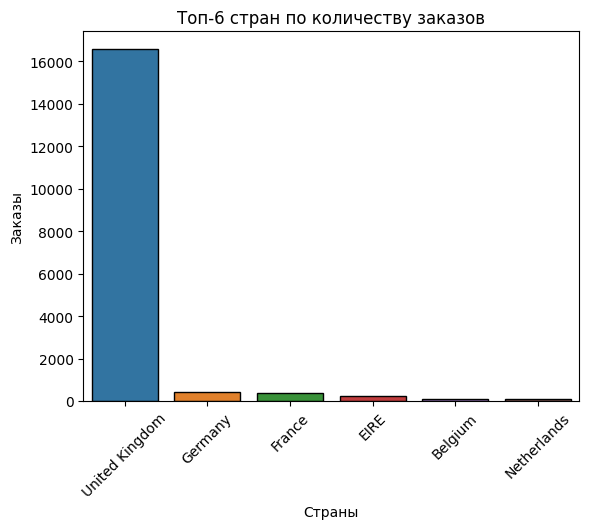

In [ ]:
# Посчитаем уникальные заказы в странах
inv_country = data.groupby('Country')['InvoiceNo'].nunique().nlargest(6)

# Построим столбчатую диаграмму
barplot = sns.barplot(
    x=inv_country.index,
    y=inv_country.values
);

barplot.set_title('Топ-6 стран по количеству заказов');
barplot.set_xlabel('Страны');
barplot.set_ylabel('Заказы');
barplot.set_xticklabels(labels=inv_country.index, rotation=45);

### Задание 4.3
Давайте добавим в датасет общую цену заказа, назовём её TotalPrice.
Общая цена заказа рассчитывается как:

 **общая цена = цена за единицу товара * (количество товаров в заказе - количество возвращённых товаров).**

Чему равна средняя общая стоимость заказов? Ответ приведите в фунтах стерлингов и округлите до целого числа.



In [6]:
data['TotalPrice'] = data['UnitPrice'] * (data['Quantity'] - data['QuantityCanceled'])
print('Средняя общая стоимость заказов составила {} фунт стерлингов.'.format(int(round(data['TotalPrice'].mean(),0))))

Средняя общая стоимость заказов составила 21 фунт стерлингов.


### Задание 4.4

Постройте визуализацию и выделите топ-3 стран, клиенты из которых приносят компании больше всего выручки:
* Великобритания (United Kingdom)
* Германия (Germany)
* Франция (France)
* Нидерланды (Netherlands)
* Ирландия (EIRE)
* Австралия (Australia)


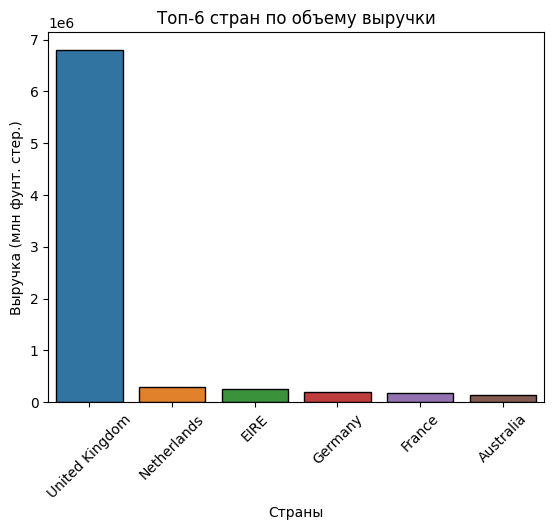

In [ ]:
# Посчитаем выручку в странах
ttl_country = data.groupby('Country')['TotalPrice'].sum().nlargest(6)

# Построим столбчатую диаграмму
barplot = sns.barplot(
    x=ttl_country.index,
    y=ttl_country.values
);

barplot.set_title('Топ-6 стран по объему выручки');
barplot.set_xlabel('Страны');
barplot.set_ylabel('Выручка (млн фунт. стер.)');
barplot.set_xticklabels(labels=ttl_country.index, rotation=45);

> Интересно, что Нидерланды находятся на шестом месте по количеству заказов, однако из-за того что эти заказы оптовые, по выручке Нидерланды расположились на втором месте.  

Теперь займёмся временными характеристиками.


### Задание 4.5
Добавьте в таблицу с транзакциями признаки месяца, дня недели и часа совершения покупки.

Постройте визуализацию, отражающую распределение суммарной выручки от заказов по месяцам. Укажите номер самого прибыльного для компании месяца. Предположите, почему так происходит.

In [7]:
data['InvoiceMonth'] = data['InvoiceDate'].dt.month
data['InvoiceWeekDay'] = data['InvoiceDate'].dt.day_name()
data['InvoiceHour'] = data['InvoiceDate'].dt.hour

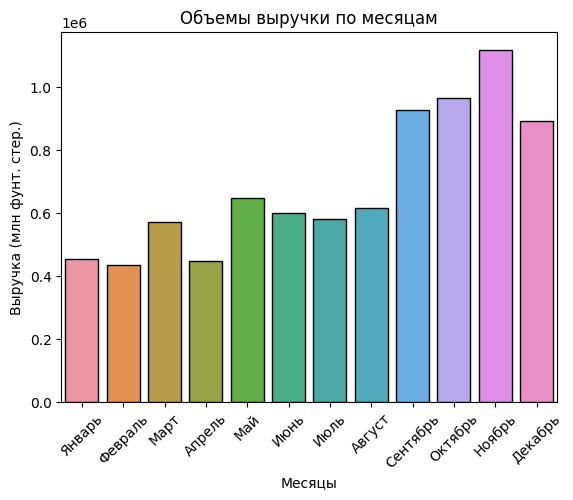

In [ ]:
# Посчитаем выручку по месяцам
rev_month = data.groupby('InvoiceMonth')['TotalPrice'].sum()
months = ['Январь', 'Февраль' , 'Март', 'Апрель', 'Май', 'Июнь', 'Июль', 'Август', 'Сентябрь', 'Октябрь', 'Ноябрь', 'Декабрь']

# Построим столбчатую диаграмму
barplot = sns.barplot(
    x=rev_month.index,
    y=rev_month.values
);

barplot.set_title('Объемы выручки по месяцам');
barplot.set_xlabel('Месяцы');
barplot.set_ylabel('Выручка (млн фунт. стер.)');
barplot.set_xticklabels(labels=months, rotation=45);

> Самым прибыльным месяцем является ноябрь. Такой результат объясняется довольно просто: ноябрь предшествует декабрю, а в декабре отмечаются католическое Рождество и Новый год. Так как мы анализируем данные магазина подарков, то совсем не удивительно, что мы видим максимальный рост продаж в преддверии этих праздников.  

### Задание 4.6
Постройте визуализацию, отражающую распределение среднего количества заказов по дням недели. Укажите день недели, в который, согласно данным, не совершено ни одного заказа:
* Понедельник
* Вторник
* Среда
* Четверг
* Пятница
* Суббота
* Воскресенье


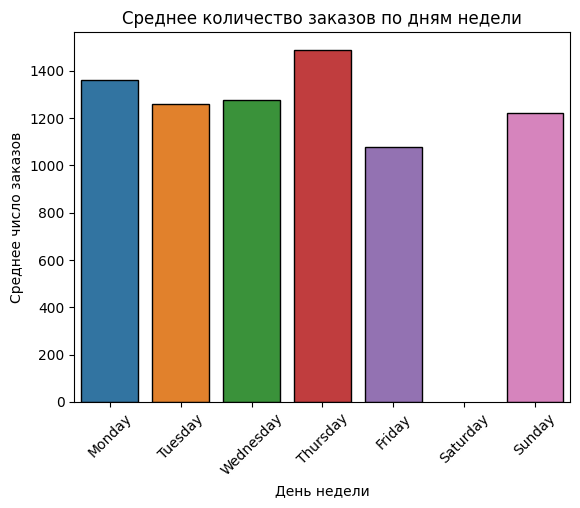

In [ ]:
# Сперва выделим признаки недели и года
data['InvoiceWeek'] = data['InvoiceDate'].dt.isocalendar().week
data['InvoiceYear'] = data['InvoiceDate'].dt.year

# Сгруппируем по году, недели и дню и посчитаем сумму заказов
alldays = data.groupby(['InvoiceYear', 'InvoiceWeek', 'InvoiceDay'])['InvoiceNo'].count().unstack()
alldays.reset_index(inplace=True)

# Вычислим среднее по количеству заказов на каждый день
inv_day_mean = alldays.iloc[:, 2:].mean(axis=0)

# Зададим порядок дней недели для диаграммы
week_days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

# Построим диаграмму
barplot = sns.barplot(
    x = inv_day_mean.index,
    y = inv_day_mean.values,
    order = week_days
);
barplot.set_title('Среднее количество заказов по дням недели');
barplot.set_xlabel('День недели');
barplot.set_ylabel('Среднее число заказов');
barplot.set_xticklabels(labels=week_days, rotation=45);

# Удалим два ненужных более признака
data.drop(['InvoiceWeek', 'InvoiceYear'], axis=1, inplace=True)

> Как видно на диаграмме, ни один заказ не был оформлен в субботу. Предположить, что суббота более важный выходной день, чем воскресенье по всему миру, да так, что в этот день не совершаются покупки, представляется маловероятным. Так что, либо это политика магазина - не проводить транзакции по субботам, либо - что наиболее вероятно - ошибка в данных.  

### Задание 4.7
Выделите дату из признака времени совершения транзакции.
Сгруппируйте данные по датам и часам совершения транзакции и найдите количество заказов на каждый день-час. Затем найдите среднее количество ежедневно поступающих заказов в каждый из часов.

Постройте визуализацию, отражающую распределение среднего количества ежедневно поступающих заказов по времени суток (часу совершения транзакции).

Выберите верные утверждения:
* [ ] Больше всего заказов совершается в вечернее время в интервале от 18 до 20 часов
* [X] Больше всего заказов совершается в дневное время в интервале от 10 до 15 часов
* [X] Начиная с 21 часа вечера и до 6 утра (не включительно) заказы не поступают
* [ ] Заказы поступают во все периоды дня


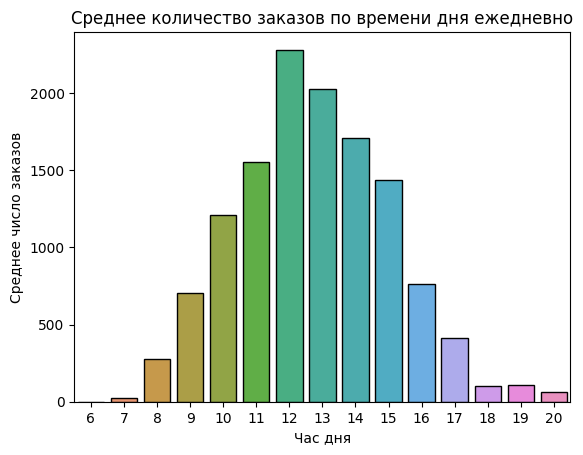

In [8]:
# Выделим признак даты
data['InvoiceDay'] = data['InvoiceDate'].dt.day

# Сгруппируем данные по дням и часам, посчитаем сумму заказов и вычислим среднее
inv_hour = data.groupby(['InvoiceDay', 'InvoiceHour'])['InvoiceNo'].count().unstack()
inv_hour_mean = inv_hour.mean()

# Построим диаграмму
barplot = sns.barplot(
    x = inv_hour_mean.index,
    y = inv_hour_mean.values
);
barplot.set_title('Среднее количество заказов по времени дня ежедневно');
barplot.set_xlabel('Час дня');
barplot.set_ylabel('Среднее число заказов');

## 5. RFM-сегментация клиентов: часть 1

Мы добрались до самой интересной части нашей задачи. Нам предстоит сформировать признаки, на основе которых мы будем производить сегментацию клиентов.

Для этого давайте познакомимся с очень популярным методом для анализа потребительской ценности под названием RFM.

<center> <a href=https://miro.medium.com/max/1400/1*uYQjy9SUjW7iWHc2gGanQQ.png><img src=img/RFM-model.png align="right" width="400"/></a> </center>
  
    
      
Метод заключается в группировке клиентов на основе следующих параметров:
* Recency (Давность) — давность последней покупки клиента;
* Frequency (Частота) — общее количество покупок клиента;
* Monetary Value (Денежная ценность) — сколько денег потратил клиент.


Суть RFM-анализа состоит в том, что мы разделяем всех клиентов на группы в зависимости от того, как давно они сделали последнюю покупку, как часто покупали и насколько большой была сумма их заказов.





Например, вот так может выглядеть интерпретация кластеров для случая RF-сегментации (анализа на основе давности и частоты заказов клиента):

<a href=https://retailrocket.ru/wp-content/uploads/2017/06/rfm-1.png><img src=img/RF-clusters.png></a>

Задача маркетологов — вести клиента в зону лояльных.

Мы можем рассчитать RFM-характеристики для каждого из клиентов в нашем датасете и на их основе с помощью методов кластеризации построить подобные сегменты клиентов, привязанные к нашим данным.

### Задание 5.1

Итак, приступим к созданию нашей RFM-таблицы.

Чтобы получить RFM-таблицу, нам необходимо сгруппировать данные по идентификаторам клиента и рассчитать следующие  агрегированные характеристики:

* Recency для i-го клиента рассчитывается как разница между датой и временем последнего заказа и точкой отсчёта, переведённая в дни:
$t_0-max(t_{i1}, t_{i2},..., t_{iM})$

    где $t_{ij}$ — дата и время совершения i-ым клиентом своей j-ой покупки.

    В качестве точки отсчёта $t_0$ берём дату на один день «старше», чем все наши данные. Это будет 10 декабря 2011 года (в формате datetime — '2011-12-10 00:00:00').

* Frequency рассчитывается как общее количество уникальных заказов, которые совершил i-ый клиент.
* Monetary Value рассчитывается как общая сумма денег, которую i-ый клиент потратил на наши товары (с учетом возвратов).

Когда вы рассчитаете все характеристики, не забудьте дать столбцам результирующей таблицы соответствующие названия.

In [9]:
# Объявим переменную с точкой отсчета
t0 = pd.to_datetime('2011-12-10 00:00:00')

# Сгруппируем данные и рассчитаем требуемые характеристики
rfm_table = data.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (t0-max(x)).days,
    'InvoiceNo': pd.Series.nunique,
    'TotalPrice': sum
})

# Переименуем столбцы
rfm_table.rename(columns={'InvoiceDate': 'Recency',
                          'InvoiceNo': 'Frequency',
                          'TotalPrice' : 'Monetary'},
                 inplace=True
)

rfm_table.head()

,Recency,Frequency,Monetary
CustomerID,,,
12346,325,1,0.00
12347,2,7,4310.00
12348,75,4,1437.24
12349,18,1,1457.55
12350,310,1,294.40


1) Сколько клиентов совершили покупку более 200 дней назад?

2) Сколько заказов в среднем делает клиент (за представленный годовой период)? Ответ округлите до целого числа.

3) Чему равна общая сумма денег, которую потратил клиент с идентификатором 12360? Ответ приведите в фунтах стерлингов и округлите до целого числа.



In [10]:
print('Ответим на вопросы:\n')
print('1) Количество клиентов, совершивших покупку более 200 дней назад:', rfm_table[rfm_table['Recency'] > 200].shape[0])
print('2) Среднее количество заказов, которые делают клиенты:', int(rfm_table['Frequency'].mean().round()))
print('3) Клиент с ID 12360 потратил в сумме', int(rfm_table.loc[12360, 'Monetary'].round()), 'фунта стерлингов.')

Ответим на вопросы:

1) Количество клиентов, совершивших покупку более 200 дней назад: 743
2) Среднее количество заказов, которые делают клиенты: 4
3) Клиент с ID 12360 потратил в сумме 2302 фунта стерлингов.


Теперь давайте взглянем на коробчатые диаграммы для каждого из признаков:

In [ ]:
boxes = [px.box(rfm_table, x=column) for column in rfm_table.columns]
fig = make_subplots(
    rows=1, cols=3,
    subplot_titles=(
        "Recency","Frequency", "Monetary"
    )
)

for i, box in enumerate(boxes):
    fig.add_trace(boxes[i]['data'][0], row=1, col=i+1)

fig.update_layout(showlegend=True)
#fig.write_html('/content/drive/MyDrive/Colab Notebooks/data/plotly_boxplot_1.html')
fig.show()

[![RFM-характеристики с выборосами](img/plotly_boxplot_1.png 'Нажмите, чтобы перейти к интерактивному графику')](http://htmlpreview.github.io/?https://github.com/StasBard/SF_DataScience/blob/master/Projects/Project_6/img/plotly_boxplot_1.html)

Что интересного здесь можно увидеть? Есть клиенты с аномально большим количеством сделанных заказов (более 100 штук), а также клиенты, общая стоимость заказов которых превышает 190 тысяч фунтов стерлингов.

Чем это плохо? Выбросы могут отрицательно сказаться на результатах работы методов кластеризации, неустойчивых к ним, например алгоритма KMeans, поэтому хотелось бы от них избавиться. Однако терять много ценных данных о клиентах тоже не хочется, поэтому ограничимся верхней границей соответствующей квантили уровня 0.95. Таким образом, мы удалим данные тех клиентов, для которых значение параметра Frequency или параметра Monetary выше, чем у 95 % клиентов.


### Задание 5.2
Удалите из RFM-таблицы записи о клиентах, для которых выполняется хотя бы одно из условий:

$$frequency >frequency_{0.95}$$
$$monetary >monetary_{0.95}$$

где $frequency_{0.95}$ и $monetary_{0.95}$ - квантили уровня 0.95 для соответствующих признаков.

Данные о скольких клиентах у вас остались в RFM-таблице?


In [11]:
# Выберем клиентов, подпадающих под условия, сохраним индексы таблицы
f_ind = list(rfm_table[rfm_table['Frequency'] > rfm_table['Frequency'].quantile(0.95)].index)
m_ind = list(rfm_table[rfm_table['Monetary'] > rfm_table['Monetary'].quantile(0.95)].index)

# Сформируем список индексов для удаления, избегая дублирования
drop_ind = set(f_ind + m_ind)

# Удаляем записи и выводим информацию об оставшихся
rfm_table_cleaned = rfm_table.drop(index=drop_ind, axis=0)
print(f'В RFM-таблице осталось {rfm_table_cleaned.shape[0]} записи.')

В RFM-таблице осталось 4044 записи.


После удаления выбросов у вас должны получиться следующие коробчатые диаграммы:


In [ ]:
boxes = [px.box(rfm_table_cleaned, x=column) for column in rfm_table_cleaned.columns]
fig = make_subplots(
    rows=1, cols=3,
    subplot_titles=(
        "Recency", "Frequency", "Monetary"
    )
)

for i, box in enumerate(boxes):
    fig.add_trace(boxes[i]['data'][0], row=1, col=i+1)

fig.update_layout(showlegend=True)
#fig.write_html('/content/drive/MyDrive/Colab Notebooks/data/plotly_boxplot_2.html')
fig.show()

[![RFM-характеристики без выборосов](img/plotly_boxplot_2.png 'Нажмите, чтобы перейти к интерактивному графику')](http://htmlpreview.github.io/?https://github.com/StasBard/SF_DataScience/blob/master/Projects/Project_6/img/plotly_boxplot_2.html)

Мы наконец добрались до этапа кластеризации. Для начала нам необходимо оценить, как распределены наблюдения в пространстве признаков. Благо, у нас всего три параметра, по которым мы хотим кластеризовать клиентов, поэтому данные можно визуализировать в виде трёхмерной диаграммы рассеяния.

Построим визуализацию нашего трёхмерного пространства признаков:


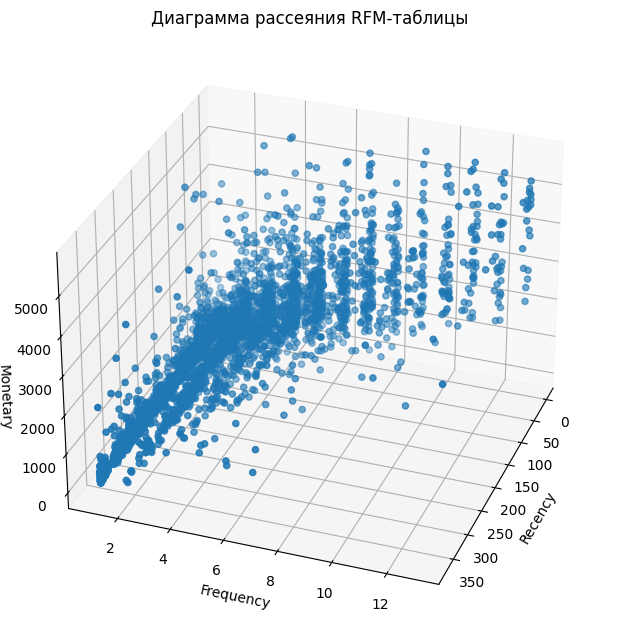

In [ ]:
# создадим трёхмерный объект
fig = plt.figure(figsize=(6,6))
ax = Axes3D(fig)
# добавим дополнительную ось в объект картинки
fig.add_axes(ax)
ax.azim = 20
ax.elev = 30

# визуализируем данные, передав значения x, y, z, а также информацию о группировке данных по цветам
ax.scatter(
    rfm_table_cleaned['Recency'].to_list(),
    rfm_table_cleaned['Frequency'].to_list(),
    rfm_table_cleaned['Monetary'].to_list()
)
# добавим оси
ax.set_xlabel('Recency');
ax.set_ylabel('Frequency');
ax.set_zlabel('Monetary');
ax.set_title('Диаграмма рассеяния RFM-таблицы');


Что здесь можно увидеть? На самом деле, ничего конкретного. Да, видно, что есть клиенты с большими значениями параметров Monetary и Frequency — вероятно, это лучшие клиенты, которые покупают чаще всего и приносят больше всего денег. Однако по общей массе точек сложно сказать, сколько кластеров у нас есть — скорее даже кажется, что пространство не поддаётся кластеризации.

Давайте призовём на помощь методы снижения размерности.


### Задание 5.3
Начнём с метода главных компонент (PCA). Нам известно, что для его стабильной работы данные необходимо стандартизировать/нормализовать.

Давайте для удобства обернём эти шаги по предобработке данных в pipeline.

Создайте pipeline, в котором будут следующие шаги:
* стандартизация с помощью StandardScaler с параметрами по умолчанию;
* метод главных компонент с двумя компонентами.

Обучите ваш pipeline на RFM-таблице, очищенной от выбросов, и примените к ней трансформацию.

Какую долю дисперсии исходных данных объясняет первая главная компонента? Ответ округлите до двух знаков после точки-разделителя.



In [12]:
# Создаем объект класса pipeline
pipe = pipeline.Pipeline([
    ('scaler', preprocessing.StandardScaler()),
    ('pca', decomposition.PCA(n_components=2))
])
# Обучаем его и преобразуем таблицу
rfm_table_processed = pipe.fit_transform(rfm_table_cleaned)

#Выводим ответ на вопрос
print('Доли дисперсии, объясняемые главными компонентами:', pipe['pca'].explained_variance_ratio_)
print('Первая главная компонента объясняет долю, равную {:.2g}'.format(pipe['pca'].explained_variance_ratio_[0]))

Доли дисперсии, объясняемые главными компонентами: [0.67747053 0.24012744]
Первая главная компонента объясняет долю, равную 0.68


Визуализировав пространство главных компонент после декомпозиции, мы получим следующую картину:

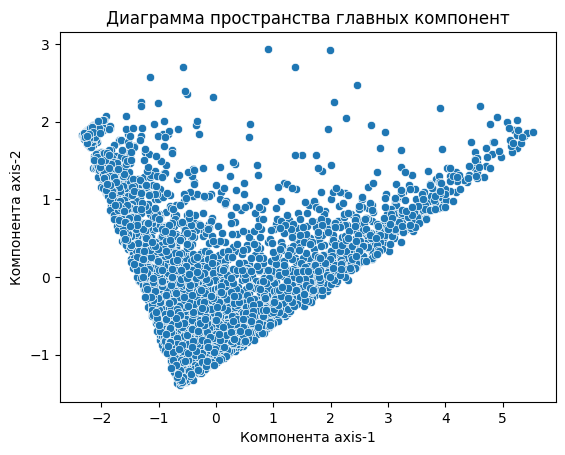

In [ ]:
rfm_table_processed = pd.DataFrame(rfm_table_processed, columns=['axis-1', 'axis-2'])
scatterplot = sns.scatterplot(
    data = rfm_table_processed,
    x = 'axis-1',
    y = 'axis-2'
);
scatterplot.set_title('Диаграмма пространства главных компонент');
scatterplot.set_xlabel('Компонента '+rfm_table_processed.columns[0]);
scatterplot.set_ylabel('Компонента '+rfm_table_processed.columns[1]);

Попробуем разделить это пространство главных компонент на сегменты.

### Задание 5.4
Попробуем воспользоваться методом k-means.

Подберите оптимальное количество кластеров для метода k-means с помощью коэффициента силуэта, перебирая возможные значения от 2 до 10 включительно.

В качестве значения параметра random_state возьмите число 42. Остальные параметры оставьте по умолчанию.

1) Судя по полученным результатам, какое количество кластеров лучше всего взять?

2) Чему равно максимальное значение коэффициента силуэта? Ответ округлите до двух знаков после точки-разделителя.


,Cluster,Sil_Score
1,3,0.524230
0,2,0.500296
2,4,0.497553


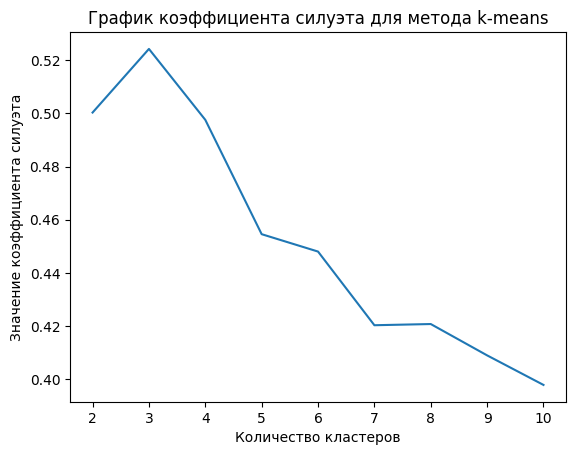

In [ ]:
silhouettes = []
clusters = range(2, 11)

for c in clusters:
    km = cluster.KMeans(random_state=42, n_clusters=c, n_init=10)
    c_pred = km.fit_predict(rfm_table_processed)
    silhouettes.append((c, metrics.silhouette_score(rfm_table_processed, c_pred)))

# Преобразуем список коэффициентов в датафрейм и выведем топ-3 значений
silhouette_df = pd.DataFrame(silhouettes, columns=['Cluster', 'Sil_Score']).sort_values(by='Sil_Score', ascending=False)
display(silhouette_df[:3])

# Построим график силуэта
lineplot = sns.lineplot(
    data = silhouette_df,
    x = 'Cluster',
    y = 'Sil_Score'
);
lineplot.set_title('График коэффициента силуэта для метода k-means');
lineplot.set_xlabel('Количество кластеров');
lineplot.set_ylabel('Значение коэффициента силуэта');

> С точки зрения метода k_means, оптимальным количеством кластеров является 3, а максимальное значение коэффициента силуэта, достигаемое при этом, равно 0.52.  

### Задание 5.5
Теперь возьмём EM-алгоритм.

Подберите оптимальное количество кластеров для EM-алгоритма (GaussianMixture) с помощью коэффициента силуэта, перебирая возможные значения от 2 до 10 включительно.
В качестве значения параметра random_state возьмите число 42. Остальные параметры оставьте по умолчанию.


1) Судя по полученным результатам, какое количество кластеров лучше всего взять?

2) Чему равно максимальное значение коэффициента силуэта? Ответ округлите до двух знаков после точки-разделителя.


,Cluster,Sil_Score
1,3,0.436061
2,4,0.350103
0,2,0.342484


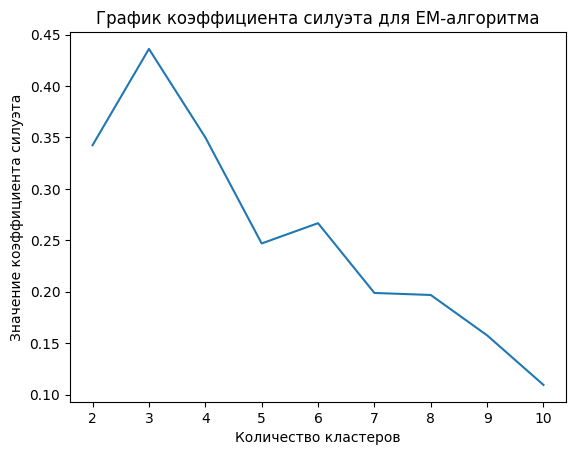

In [ ]:
silhouettes = []
clusters = range(2, 11)

for c in clusters:
    gm = mixture.GaussianMixture(random_state=42, n_components=c)
    c_pred = gm.fit_predict(rfm_table_processed)
    silhouettes.append((c, metrics.silhouette_score(rfm_table_processed, c_pred)))

# Преобразуем список коэффициентов в датафрейм и выведем топ-3 значений
silhouette_df = pd.DataFrame(silhouettes, columns=['Cluster', 'Sil_Score']).sort_values(by='Sil_Score', ascending=False)
display(silhouette_df[:3])

# Построим график силуэта
lineplot = sns.lineplot(
    data = silhouette_df,
    x = 'Cluster',
    y = 'Sil_Score'
);
lineplot.set_title('График коэффициента силуэта для EM-алгоритма');
lineplot.set_xlabel('Количество кластеров');
lineplot.set_ylabel('Значение коэффициента силуэта');

> Согласно EM-алгоритму, оптимальным количеством кластеров является 3, а максимальное значение коэффициента силуэта, достигаемое при этом, равно 0.44 (что меньше, чем при использованиии k-means).    

### Задание 5.6
Давайте посмотрим на распределение кластеров.

1) Сначала нужно определить лучшую модель. Для какой модели с оптимальным количеством кластеров коэффициент силуэта наибольший?
* [X] K-Means
* [ ] GaussianMixture


2) Обучите лучшую модель с подобранным ранее количеством кластеров на декомпозированных данных.
Сколько клиентов попало в самый большой кластер?



In [ ]:
# Создаем и обучаем модель с тремя кластерами
km = cluster.KMeans(random_state=42, n_clusters=3, n_init=10)
c_pred = km.fit_predict(rfm_table_processed)

# Выводим кластеры с количеством клиентов в них
pd.Series(c_pred).value_counts()

2    2269
0     999
1     776
dtype: int64

> В самый большой кластер попало 2269 клиентов.  

Визуализируем результаты кластеризации:

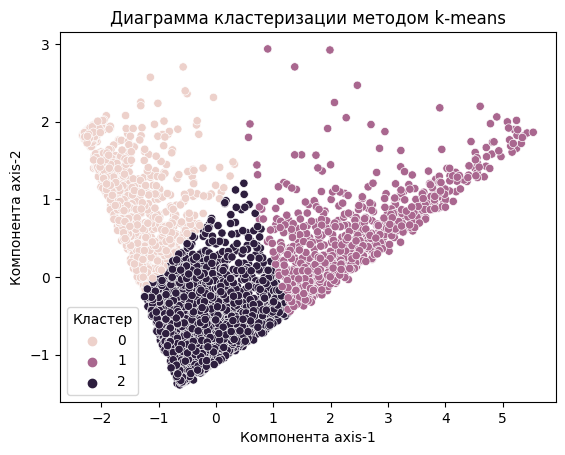

In [ ]:
# Построим диаграмму
scatterplot = sns.scatterplot(
    data=rfm_table_processed,
    x='axis-1',
    y='axis-2',
    hue=km.labels_
);
scatterplot.set_title('Диаграмма кластеризации методом k-means');
scatterplot.set_xlabel('Компонента '+rfm_table_processed.columns[0]);
scatterplot.set_ylabel('Компонента '+rfm_table_processed.columns[1]);
scatterplot.legend(title='Кластер');

Итак, у нас есть три сегмента клиентов. Давайте попробуем составить профиль для этих сегментов.

### Задание 5.7

Для составления профиля кластеров нам необходимо вернуться от декомпозированных данных к RFM-таблице, очищенной от выбросов.  Сгруппируйте RFM-таблицу по полученным кластерам и рассчитайте среднее по каждому из признаков.

Чему равно максимальное среднее значение признака Frequency в полученной таблице? Ответ округлите до целого числа.

In [ ]:
# Добавляем столбец с номерами кластеров в декомпозированную RFM-таблицу
rfm_table_cleaned['Cluster'] = c_pred

# Объединяем ее по номеру кластера и вычисляем среднее
rfm_clusters = rfm_table_cleaned.groupby('Cluster').mean()

# Выводим таблицу и ответ на вопрос на экран
display(rfm_clusters)
print('\nМаксимальное среднее значение признака Frequency равно',
      int(rfm_clusters['Frequency'].max().round()))

,Recency,Frequency,Monetary
Cluster,,,
0,253.474474,1.403403,386.277297
1,31.943299,7.068299,2657.746997
2,51.221684,2.329220,660.068947



Максимальное среднее значение признака Frequency равно 7


### Полярная диаграмма
Сейчас мы познакомимся с одним из способов визуализации профиля кластеров — Radar Chart (полярная, или лепестковая, диаграмма). Это графическое представление значений нескольких эквивалентных категорий в форме «паутины».
Radar Chart очень часто используется в контексте определения профиля кластеров. На концах «паутины» откладываются оси, которые соответствуют признакам, описывающим объекты. На каждой из осей для каждого кластера откладываются средние значения соответствующих характеристик. Соединив точки по осям, мы получаем многоугольник.
Пример полярной диаграммы для задачи кластеризации учеников по интересам:

<a href=https://www.datanovia.com/en/wp-content/uploads/2020/12/radar-chart-in-r-customized-fmstb-radar-chart-1.png><img src=img/radar-chart.png width=500></a>

На данной диаграмме мы видим визуализацию признаков для одного из кластеров. Видно, что ученики, принадлежащие к данному кластеру, в большей степени увлекаются музыкой (Music), а в меньшей степени — программированием (Programm).

В модуле graph_objects библиотеки plotly есть встроенная функция Scatterpolar, которая позволяет построить полярную диаграмму. На основе этой функции мы реализовали собственную функцию plot_cluster_profile(), которая позволяет визуализировать профиль каждого из кластеров в виде полярной диаграммы. У этой функции два параметра: grouped_data — сгруппированные по кластерам характеристики объектов (клиентов), n_clusters — количество кластеров.

Главное условие использования полярной диаграммы — все признаки должны быть приведены к единому масштабу с помощью нормализации, где 1 будет означать максимум, а 0 — минимум. Шаг с нормализацией мы также добавили в реализацию функции plot_cluster_profile().

In [ ]:
def plot_cluster_profile(grouped_data, n_clusters, title) -> None:
    """Функция строит и выводит на экран полярную диаграмму
    средних RFM-характеристик кластеров.

    Args:
        grouped_data (pd.DataFrame): датафрейм средних RFM-характеристик кластеров
        n_clusters (int): количество кластеров
        title (str): заголовок диаграммы
    """

    # Нормализуем сгруппированные данные, приводя их к масштабу 0-1.
    scaler = preprocessing.MinMaxScaler()
    grouped_data = pd.DataFrame(scaler.fit_transform(grouped_data), columns=grouped_data.columns)
    # Создаем список признаков
    features = grouped_data.columns
    # Создаем пустую фигуру
    fig = go.Figure()
    # В цикле визуализируем полярную диаграмму для каждого кластера
    for i in range(n_clusters):
        # Создаем полярную диаграмму и добавляем ее на общий график
        fig.add_trace(go.Scatterpolar(
            r=grouped_data.iloc[i].values, # радиусы
            theta=features, # название засечек
            fill='toself', # заливка многоугольника цветом
            name=f'Cluster {i}', # название - номер кластера
        ))
    # Обновляем параметры фигуры
    fig.update_layout(
        showlegend=True, # отображение легенды
        autosize=False, # устаналиваем свои размеры графика
        title=title, # название диаграммы
        width=800, # ширина (в пикселях)
        height=800, # высота (в пикселях)
    )
    # Отображаем фигуру
    fig.show()


Теперь у нас есть удобный инструмент для анализа профиля кластеров. Давайте воспользуемся им.


### Задание 5.8

Визуализируйте профили кластеров в виде полярной диаграммы на основе средних RFM-характеристик, вычисленных для каждого кластера.

Проанализируйте кластеры и на основе анализа сопоставьте номер кластера и его описание.

Описание кластера:
* Кластер `[1]` соответствует «лояльным» клиентам, которые приносят наибольший доход, совершают покупки чаще всего, а давность их последней покупки наименьшая.
* Кластер `[2]` соответствует «промежуточным» клиентам, которые являются активными, но покупают не так часто и много, как лояльные клиенты. В то же время эти клиенты не являются «потерянными».
* Кластер `[0]` соответствует «потерянным» клиентам, которые купили меньше всего товара, и их последняя покупка была совершена очень давно.


In [ ]:
plot_cluster_profile(rfm_clusters, 3, 'Полярная диаграмма средних RFM-характеристик')

![Полярная диаграмма средних RFM-характеристик](img/plotly_cluster_profile_3.png)

## 6. RFM-сегментация клиентов: часть 2

Итак, с помощью RFM-анализа нам удалось выделить три сегмента клиентов. Однако в маркетинге принято оперировать большим их количеством: обычно маркетологи стараются создать стратегию хотя бы для пяти-семи клиентских сегментов в градации от «лояльных» до «потерянных» с промежуточными категориями.

Поэтому, получив обратную связь от маркетологов, мы вновь принимаемся за работу, пытаясь модифицировать полученное решение.

Ранее мы производили кластеризацию в пространстве главных компонент. Вспомним, что PCA является линейным методом отображения исходного пространства признаков в его сжатую версию.

А что если использовать нелинейную трансформацию? Например, алгоритм снижения размерности t-SNE. Давайте попробуем и посмотрим, что получится.

### Задание 6.1
Воспользуемся алгоритмом t-SNE и трансформируем RFM-таблицу, очищенную от выбросов, в двухмерное представление. Также заранее позаботимся о масштабировании признаков.

Давайте для удобства обернём шаги по предобработке данных в pipeline.

Создайте pipeline, который будет содержать следующие шаги:
* стандартизация с помощью StandardScaler с параметрами по умолчанию;
* алгоритм t-SNE с двумя компонентами, параметрами perplexity=50 и random_state=100.

Обучите ваш pipeline на RFM-таблице (очищенной от выбросов), полученной ранее, и примените к ней трансформацию.

Чему равно значение дивергенции Кульбака — Лейблера для обученного алгоритма t-SNE? Ответ округлите до двух знаков после точки-разделителя.

**Примечание:**
Напомним, что дивергенция Кульбака-Лейблера - это функция потерь, которая минимизируется при обучения алгоритма t-SNE. Она показывает меру расстояния между двумя распределениями.

Оптимальное значение данной характеристики, найденное в процессе обучения алгоритма t-SNE, хранится в атрибуте kl_divergence_ объекта класса TSNE из библиотеки sklearn. Конечно же, предварительно модель необходимо обучить, чтобы получить это значение.



In [ ]:
# Сперва удалим из таблицы столбец с номерами кластеров
rfm_table_cleaned.drop('Cluster', axis=1, inplace=True)

In [13]:
# Создаем объект класса pipeline
pipe = pipeline.Pipeline([
    ('scaler', preprocessing.StandardScaler()),
    ('tsne', manifold.TSNE(n_components=2, perplexity=50, random_state=100))
])

# Обучаем его и преобразуем таблицу
rfm_table_processed = pipe.fit_transform(rfm_table_cleaned)

# Выводим ответ на вопрос на экран
print('Значение дивергенции Кульбака — Лейблера равно:', round(pipe['tsne'].kl_divergence_, 2))

Значение дивергенции Кульбака — Лейблера равно: 0.54


Визуализировав пространство после декомпозиции с помощью t-SNE, мы получим следующую картину:


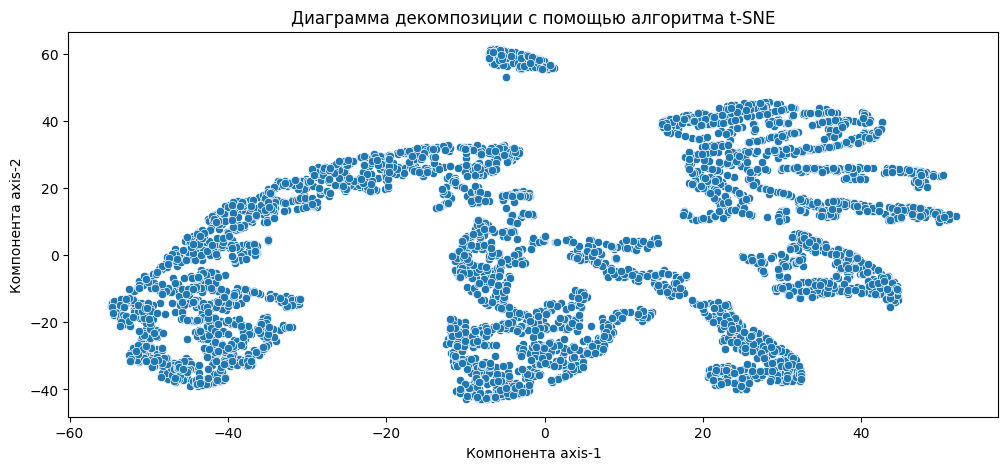

In [14]:
rfm_table_processed = pd.DataFrame(rfm_table_processed, columns=['axis-1', 'axis-2'])

# Построим диаграмму
fig = plt.figure(figsize=(12, 5))
scatterplot = sns.scatterplot(
    data = rfm_table_processed,
    x = 'axis-1',
    y = 'axis-2'
);
scatterplot.set_title('Диаграмма декомпозиции с помощью алгоритма t-SNE');
scatterplot.set_xlabel('Компонента '+rfm_table_processed.columns[0]);
scatterplot.set_ylabel('Компонента '+rfm_table_processed.columns[1]);

Как и ожидалось от t-SNE, алгоритм сгруппировал наиболее похожие объекты в подобие кластеров, причём эти кластеры легко определить.

Теперь давайте воспользуемся алгоритмами кластеризации, чтобы сформировать новые сегменты клиентов.


### Задание 6.2
Попробуем воспользоваться методом k-means.
Подберите оптимальное количество кластеров для метода k-means с помощью коэффициента силуэта, перебирая возможные значения от 3 до 8 включительно.
В качестве значения параметра random_state возьмите число 42. Остальные параметры оставьте по умолчанию.

1) Судя по полученным результатам, какое количество кластеров лучше всего взять?

2) Чему равно максимальное значение коэффициента силуэта? Ответ округлите до двух знаков после точки-разделителя.



,Cluster,Sil_Score
4,7,0.484495
5,8,0.482026
1,4,0.479278


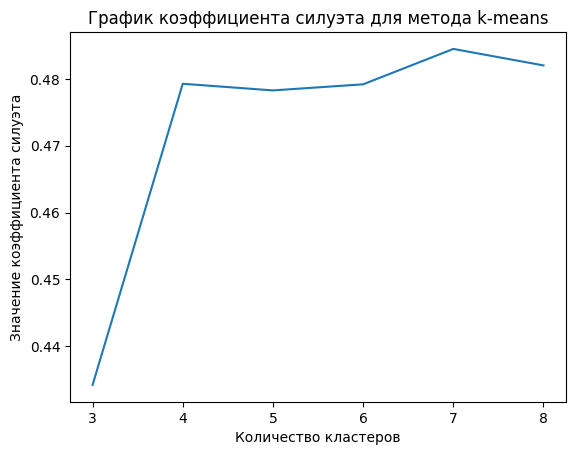

In [ ]:
silhouettes = []
clusters = range(3, 9)

for c in clusters:
    km = cluster.KMeans(random_state=42, n_clusters=c, n_init=10)
    c_pred = km.fit_predict(rfm_table_processed)
    silhouettes.append((c, metrics.silhouette_score(rfm_table_processed, c_pred)))

# Преобразуем список коэффициентов в датафрейм и выведем топ-3 значений
silhouette_df = pd.DataFrame(silhouettes, columns=['Cluster', 'Sil_Score']).sort_values(by='Sil_Score', ascending=False)
display(silhouette_df[:3])

# Построим график силуэта
lineplot = sns.lineplot(
    data = silhouette_df,
    x = 'Cluster',
    y = 'Sil_Score'
);
lineplot.set_title('График коэффициента силуэта для метода k-means');
lineplot.set_xlabel('Количество кластеров');
lineplot.set_ylabel('Значение коэффициента силуэта');

> С точки зрения метода k_means, оптимальным количеством кластеров является 7, а максимальное значение коэффициента силуэта, достигаемое при этом, равно 0.48.  

### Задание 6.3
Попробуем воспользоваться EM-алгоритом.

Подберите оптимальное количество кластеров для EM-алгоритма (GaussianMixture)  с помощью коэффициента силуэта, перебирая возможные значения от 3 до 8 включительно.

В качестве значения параметра random_state возьмите число 42. Остальные параметры оставьте по умолчанию.


1) Судя по полученным результатам, какое количество кластеров лучше всего взять?

2) Чему равно максимальное значение коэффициента силуэта? Ответ округлите до двух знаков после точки-разделителя.

,Cluster,Sil_Score
1,4,0.468827
3,6,0.457162
5,8,0.429173


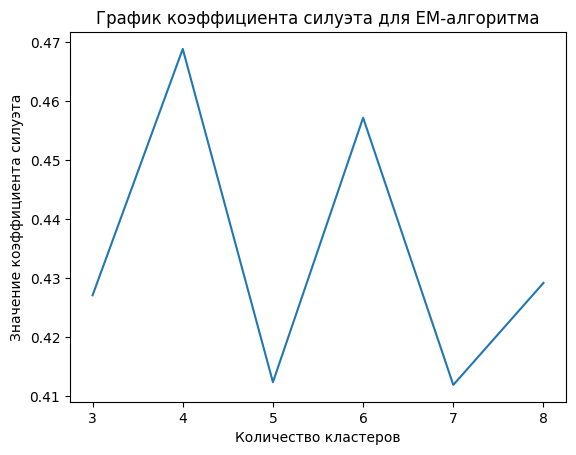

In [ ]:
silhouettes = []
clusters = range(3, 9)

for c in clusters:
    gm = mixture.GaussianMixture(random_state=42, n_components=c)
    c_pred = gm.fit_predict(rfm_table_processed)
    silhouettes.append((c, metrics.silhouette_score(rfm_table_processed, c_pred)))

# Преобразуем список коэффициентов в датафрейм и выведем топ-3 значений
silhouette_df = pd.DataFrame(silhouettes, columns=['Cluster', 'Sil_Score']).sort_values(by='Sil_Score', ascending=False)
display(silhouette_df[:3])

# Построим график силуэта
lineplot = sns.lineplot(
    data = silhouette_df,
    x = 'Cluster',
    y = 'Sil_Score'
);
lineplot.set_title('График коэффициента силуэта для EM-алгоритма');
lineplot.set_xlabel('Количество кластеров');
lineplot.set_ylabel('Значение коэффициента силуэта');

> Согласно EM-алгоритму, оптимальным количеством кластеров является 4, а максимальное значение коэффициента силуэта, достигаемое при этом, равно 0.47 (что слегка меньше, чем при использованиии k-means).    

### Задание 6.4
Наконец, попробуем воспользоваться алгоритмом алгомеративной кластеризации (AgglomerativeClustering).

Подберите оптимальное количество кластеров для алгоритма агломеративной кластеризации с помощью коэффициента силуэта, перебирая возможные значения от 2 до 8 включительно.

Все параметры, за исключением числа кластеров, оставьте по умолчанию.


1) Судя по полученным результатам, какое количество кластеров лучше всего взять?

2) Чему равно максимальное значение коэффициента силуэта? Ответ округлите до двух знаков после точки-разделителя.



,Cluster,Sil_Score
6,8,0.479046
3,5,0.470394
4,6,0.469175


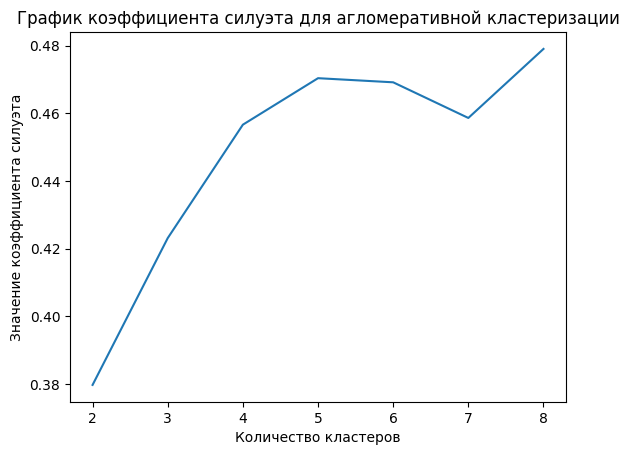

In [ ]:
silhouettes = []
clusters = range(2, 9)

for c in clusters:
    ac = cluster.AgglomerativeClustering(n_clusters=c)
    c_pred = ac.fit_predict(rfm_table_processed)
    silhouettes.append((c, metrics.silhouette_score(rfm_table_processed, c_pred)))

# Преобразуем список коэффициентов в датафрейм и выведем топ-3 значений
silhouette_df = pd.DataFrame(silhouettes, columns=['Cluster', 'Sil_Score']).sort_values(by='Sil_Score', ascending=False)
display(silhouette_df[:3])

# Построим график силуэта
lineplot = sns.lineplot(
    data = silhouette_df,
    x = 'Cluster',
    y = 'Sil_Score'
);
lineplot.set_title('График коэффициента силуэта для агломеративной кластеризации');
lineplot.set_xlabel('Количество кластеров');
lineplot.set_ylabel('Значение коэффициента силуэта');

> С помощью алгоритма агломеративной кластеризации определно оптимальное количество кластеров, равное 8, а максимальное значение коэффициента силуэта, достигаемое при этом, равно 0.48 (что выше, чем у EM-алгоритма, но ниже, чем у k-means).      

### Задание 6.5
Давайте посмотрим на распределение кластеров.

1) Сначала нужно определить лучшую модель. Для какой модели с оптимальным количеством кластеров коэффициент силуэта наибольший?
* [X] K-Means
* [ ] GaussianMixture
* [ ] AgglomerativeClustering


2) Обучите лучшую модель с подобранным ранее количеством кластеров на декомпозированных данных.
Сколько клиентов попало в самый большой кластер?



In [15]:
# Создаем и обучаем модель с семью кластерами
km = cluster.KMeans(random_state=42, n_clusters=7, n_init=10)
c_pred = km.fit_predict(rfm_table_processed)

# Выводим кластеры с количеством клиентов в них
pd.Series(c_pred).value_counts()

1    914
4    683
0    656
2    543
5    446
6    405
3    397
dtype: int64

> В самый большой кластер (1-й) попало 914 клиентов.  

Визуализируем результаты кластеризации:

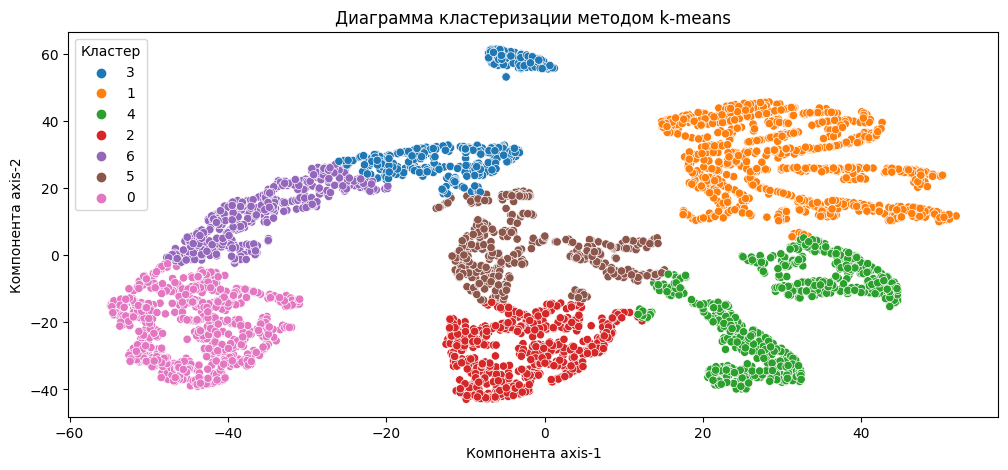

In [16]:
# Построим диаграмму
fig = plt.figure(figsize=(12, 5))
scatterplot = sns.scatterplot(
    data = rfm_table_processed,
    x = 'axis-1',
    y = 'axis-2',
    hue = km.labels_.astype('str')
);
scatterplot.set_title('Диаграмма кластеризации методом k-means');
scatterplot.set_xlabel('Компонента '+rfm_table_processed.columns[0]);
scatterplot.set_ylabel('Компонента '+rfm_table_processed.columns[1]);
scatterplot.legend(title='Кластер');


Итак, у нас есть 7 сегментов клиентов. Давайте попробуем составить профиль для этих сегментов.


### Задание 6.6

Для составления профиля кластеров нам необходимо вернуться от декомпозированных данных к RFM-таблице (очищенной от выбросов).

Сгруппируйте RFM-таблицу по полученным кластерам и рассчитайте среднее по каждому из признаков. Для наглядности округлите все значения в столбцах до целого числа.

Чему равно максимальное среднее значение признака Recency в полученной таблице? Ответ округлите до целого числа.

In [17]:
# Добавляем столбец с номерами кластеров в декомпозированную RFM-таблицу
rfm_table_cleaned['Cluster'] = c_pred

# Группируем ее по номеру кластера и вычисляем среднее
rfm_clusters = rfm_table_cleaned.groupby('Cluster').mean().round().astype('int')

# Выводим таблицу и ответ на вопрос на экран
display(rfm_clusters)
print('\nМаксимальное среднее значение признака Frequency равно',
      int(rfm_clusters['Recency'].max()))

,Recency,Frequency,Monetary
Cluster,,,
0,46,1,322
1,32,7,2417
2,40,2,614
3,313,1,261
4,40,3,995
5,196,2,670
6,181,1,273



Максимальное среднее значение признака Frequency равно 313


### Задание 6.7
Визуализируйте профили кластеров в виде полярной диаграммы на основе средних RFM-характеристик, вычисленных для каждого кластера.

Проанализируйте кластеры и на основе анализа сопоставьте номер кластера и его описание.

* Кластер `[1]` соответствует «лояльным» клиентам, которые приносят наибольший доход, совершают покупки чаще всего, а давность их последней покупки наименьшая.
* Кластер `[4]` соответствует «перспективным» клиентам, которые являются активными покупателями, но покупают не так часто и не так много, как лояльные клиенты.
* Кластер `[2]` соответствует «подвисшим» клиентам, которые относительно недавно сделали несколько заказов на небольшие суммы. Потенциально эти клиенты могут быть переведены в кластер «перспективных».
* Кластер `[5]` соответствует клиентам «в зоне риска», которые несколько раз покупали товары на небольшие суммы, однако их последняя покупка была совершена более пяти месяцев назад.
* Кластер `[0]` соответствует клиентам-«новичкам», которые относительно недавно сделали один заказ на небольшую сумму.
* Кластер `[6]` соответствует «спящим» или «почти потерянным» клиентам, которые сделали один заказ на маленькую сумму более семи месяцев назад и больше не возвращались.
* Кластер `[3]` соответствует «потерянным» клиентам, которые купили меньше всего товара, и их последняя покупка была совершена около года назад.  



In [ ]:
plot_cluster_profile(rfm_clusters, 7, 'Полярная диаграмма средних RFM-характеристик')

![Полярная диаграмма средних RFM-характеристик](img/plotly_cluster_profile_7.png)

## 7. RFM-кластеризация клиентов: часть 3

Мы построили модель кластеризации для части клиентов.Но как сделать предсказание сегмента для клиентов, которые не попали в обучающую выборку?

Вы, вероятно, скажете: «Воспользоваться методом predict()!»

Верно, однако всё не так просто.

Вспомним, что мы обучали наши алгоритмы кластеризации на сжатом с помощью t-SNE пространстве признаков. То есть, чтобы сделать предсказание для новых объектов, не попавших в выборку, нам необходимо будет совершить трансформацию признаков этих объектов в новое сжатое пространство.

Однако проблема t-SNE заключается в том, что алгоритм непараметрический. Это значит, что он, в отличие от таких алгоритмов, как PCA и SVD, не создаёт явной функции отображения. Проще говоря, алгоритм трансформирует пространство признаков для обучающей выборки, но не запоминает, каким образом это делает. Это значит, что, передав в алгоритм новые объекты для сжатия пространства, мы получим абсолютно новое представление пространства, не имеющее отношения к тому, что мы построили для обучающей выборки. То есть произойдёт искажение, что может привести к неверным результатам кластеризации.

Именно поэтому у класса TSNE из библиотеки sklearn нет такого метода, как transform(), у него есть только метод fit_transform() — заново обучить алгоритм t-SNE и произвести трансформацию.

Как же тогда производить кластеризацию для новых объектов, если мы не можем сжимать размерность для новых данных?

Давайте сведём задачу кластеризации к задаче классификации. Действительно, у нас теперь есть истинные метки кластеров, а есть клиенты, которые описываются RFM-характеристиками. Давайте обучим модель, которая на основе RFM-характеристик будет предсказывать клиентский сегмент.

### Задание 7.1

Разделите исходные данные на тренировочную и тестовую выборки в соотношении 80/20. В качестве параметра random_state возьмите число 42.

Сколько клиентов попали в тестовую выборку?

In [18]:
# Создаём матрицу наблюдений X и вектор правильных ответов y
X = rfm_table_cleaned.drop('Cluster', axis=1) # RFM-таблица без столбца кластеров
y = rfm_table_cleaned['Cluster'] # метки кластеров, предсказанные ранее

# Разделяем выборку
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.2, random_state=42)

# Выводим ответ на вопрос
print(f'В тестовую выборку попало {len(y_test)} клиентов.')

В тестовую выборку попало 809 клиентов.


Дальше нам осталось только построить несколько моделей и выбрать из них лучшую.
Мы знаем, что алгоритм t-SNE является нелинейным методом понижения размерности. Можно смело предположить, что линейные модели, такие как логистическая регрессия, в данной задаче нам мало чем помогут (можете убедиться в этом самостоятельно, обучив модель логистической регрессии на тренировочной выборке и оценив качество на тестовой).

Поэтому давайте сразу возьмём тяжелую артиллерию — ансамблевые алгоритмы.


### Задание 7.2
Начнём со случайного леса. С помощью GridSearchCV организуйте перебор параметров случайного леса (RandomForestClassifier) на следующей сетке параметров:

```
param_grid = {
    'max_depth': range(5, 15),
    'criterion': ['gini', 'entropy'],
    'n_estimators': [100, 200, 500]
}
```
В качестве параметра random_state для модели случайного леса используйте число 42.
В качестве метрики используйте accuracy. Количество фолдов для кросс-валидации — 5.

1) Обучите GridSearchCV на тренировочной выборке. Чему равна оптимальная максимальная глубина деревьев в случайном лесу?

2) С помощью лучшей модели сделайте предсказание для тестовой выборки и рассчитайте метрику accuracy. Ответ округлите до трёх знаков после точки-разделителя.



In [ ]:
# Задаем сетку параметров
param_grid = {
    'max_depth': range(5, 15),
    'criterion': ['gini', 'entropy'],
    'n_estimators': [100, 200, 500]
}

# Создаем модель
grid = model_selection.GridSearchCV(
    estimator = ensemble.RandomForestClassifier(random_state=42),
    param_grid = param_grid,
    scoring = 'accuracy',
    cv = 5,
    n_jobs = -1
)

# Обучаем модель и выводим оптимальные параметры
grid.fit(X_train, y_train)
print('Оптимальные параметры:',grid.best_params_)

Оптимальные параметры: {'criterion': 'gini', 'max_depth': 13, 'n_estimators': 200}


In [ ]:
# Создаем модель случайного леса с наилучшими параметрами
rf = grid.best_estimator_

# Выполняем предсказание
y_test_pred = rf.predict(X_test)

# Рассчитываем и выводим на экран метрику
print('Значение метрики accuracy на тестовой выборке:', metrics.accuracy_score(y_test, y_test_pred).round(3))

Значение метрики accuracy на тестовой выборке: 0.985


> Оптимальная глубина деревьев в случайном лесу равна 13, а значение метрики accuracy на тестовой выборке при оптимальных параметрах составило 0.985.  

Итак, значение метрики accuracy очень высокое, но не идеальное. Давайте попробуем его улучшить, воспользовавшись бустингом.

### Задание 7.3
С помощью GridSearchCV организуйте перебор параметров градиентного бустинга (GradientBoostingClassifier) на следующей сетке параметров:
```
param_grid = {
    'max_depth': range(3, 7),
    'learning_rate': [0.001, 0.01, 0.1],
    'n_estimators': [100, 200, 500]
}
```

В качестве параметра random_state для модели градиентного бустинга используйте число 42.
В качестве метрики используйте accuracy. Количество фолдов для кросс-валидации — 5.

1) Обучите GridSearchCV на тренировочной выборке. Чему равна оптимальная максимальная глубина деревьев в градиентном бустинге?  

2) С помощью лучшей модели сделайте предсказание для тестовой выборки и рассчитайте метрику accuracy. Ответ округлите до трёх знаков после точки-разделителя.



In [19]:
# Задаем сетку параметров
param_grid = {
    'max_depth': range(5, 8),
    'learning_rate': [0.001, 0.01, 0.1],
    'n_estimators': [100, 200, 500]
}

# Создаем модель
gs = model_selection.GridSearchCV(
    estimator = ensemble.GradientBoostingClassifier(random_state=42),
    param_grid = param_grid,
    scoring = 'accuracy',
    cv = 5,
    n_jobs = -1
)

# Обучаем модель и выводим оптимальные параметры
gs.fit(X_train, y_train)
print('Оптимальные параметры:',gs.best_params_)


# Создаем модель градиентного бустинга с наилучшими параметрами
gb = gs.best_estimator_

# Выполняем предсказание
y_test_pred = gb.predict(X_test)

# Рассчитываем и выводим на экран метрику
print('Значение метрики accuracy на тестовой выборке:', metrics.accuracy_score(y_test, y_test_pred).round(3))

Оптимальные параметры: {'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 100}
Значение метрики accuracy на тестовой выборке: 0.989


> Благодаря модели градиентного бустинга нам удалось улучшить значение метрики accuracy на тестовой выборке до 0.989! Оптимальная глубина деревьев при этом равна 6.  

Отлично, мы справились с проблемой непараметричности t-SNE и смогли перейти от решения задачи кластеризации к задаче классификации. Теперь у нас есть модель, которая на основе RFM-характерик клиента автоматически определяет его сегмент.

### Задание 7.4

Посмотрим на работу классификатора на "новых" клиентах. Используем для этого записи о клиентах, суммарная прибыль от которых (`Monetary value`) превысила 0.95 квантиль:
$$monetary >monetary_{0.95}$$  
Напомним, что в задании 5.2 мы отсеяли их как выбросы.  

Исходя из полярной диаграммы, клиенты, которые приносят наибольший доход, принадлежат к кластеру `[1]`. Проверим это.  

In [28]:
#Формируем валидационную выборку из отсеянных клиентов
X_valid = rfm_table.loc[m_ind,:]
print('Количество клиентов в валидационной выборке:', len(m_ind))

# Выполняем предсказание c помощью обученной выше модели
y_valid_pred = gb.predict(X_valid)

display('Кластер клиентов валидационной выборки:', pd.Series(y_valid_pred).value_counts())

Количество клиентов в валидационной выборке: 217


'Кластер клиентов валидационной выборки:'

1    217
dtype: int64

> Итак, модель отнесла всех клиентов, приносящих повышенный доход, к 1-му кластеру, что согласуется с логикой нашего разбиения.  
> Таким образом, мы и правильно выполнили сегментацию на кластеры, и правильно выбрали и обучили модель классификатора.  
> Теперь с появлением данных о новых клиентах мы можем сразу же подавать их на вход обученной модели, определять их принадлежность к одному из кластеров и на этом строить оптимальную стратегию взаимодействия с ними.  

## Выводы по проекту

1. В ходе работы над проектом была **решена бизнес-задача - произведена сегментацая существующих клиентов, интерпретация этих сегментов для определения стратегии последующего взаимодействия с ними.**.  

2. Также была **решена и техническая задача области Data Science - построение модели кластеризации клиентов на основе их покупательской способности, частоты заказов и срока давности последней покупки (RFM-анализ).** В результате работы модели, определены и проинтерпретированы 7 кластеров клиентов.  

3. Наконец, мы **успешно обучили модель предсказывать категорию клиента** и протестировали ее на новых данных, решив задачу классификации.  

4. Таким образом, мы достигли всех поставленных в начале проекта целей. Вместе с тем, выходя за рамки заданий, можно наметить следующие направления улучшения кластеризации нашего датасета:

  * Выделить оптовиков в отдельный сегмент. В таком случае идея метода RFM расширяется путём добавления в датасет информации о среднем количестве покупаемого товара за один заказ. То есть аббревиатура RFM превращается в RFMQ, где Q — среднее количество товаров в одном заказе.   
  * Произвести кластерный анализ товаров на основе их описания и сформировать категории, по которым совершаются покупки.  
  * Рассчитать частоту покупки каждой категории товаров для каждого клиента. Эта информация может стать основой для построения модели кластеризации и сегментирования клиентов по их интересам.   
  * Наконец, воспользоваться информацией о сезонности покупок и добавить в модель информацию о частоте покупок клиентов в каждый из месяцев. Так можно определить, какие клиенты являются постоянными, то есть их покупки не зависят от сезона, а какие покупают товары только в преддверии праздников. Эта информация позволит экспериментировать с маркетинговой кампанией и повышать лояльность клиентов.

___